In this notebook we study the tradeoff between
nat-err and rob-err
for SVMs on MNIST and CIFAR10.

## Set up libraries

In [2]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

In [3]:
from typing import Dict, Tuple

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

import thundersvm

import jax
import jax.numpy as jnp
from jax.interpreters import xla
jax.config.update("jax_enable_x64", True)
#jax.config.update("jax_platform_name", "cpu")

import neural_tangents as nt
from neural_tangents import stax

jnp.array([0]) # So warnings don't show up later
jax.local_devices()

[GpuDevice(id=0, task=0)]

In [4]:
import sys
sys.path.append("../..")

from adversarial_ntks import dataset, attacks, jthunder, kernel

## Load Data

In [5]:
%%time

MNIST_TRAIN = dataset.get_np_data(
    name="mnist", split="train", binary_labels=True)
MNIST_TEST = dataset.get_np_data(
    name="mnist", split="test", binary_labels=True)

CIFAR_TRAIN = dataset.get_np_data(
    name="cifar10", split="train", binary_labels=True)
CIFAR_TEST = dataset.get_np_data(
    name="cifar10", split="test", binary_labels=True)

print(MNIST_TRAIN.xs.shape)
print(MNIST_TEST.xs.shape)
print(CIFAR_TRAIN.xs.shape)
print(CIFAR_TEST.xs.shape)

(60000, 784)
(10000, 784)
(50000, 3072)
(10000, 3072)
CPU times: user 21 s, sys: 18.4 s, total: 39.5 s
Wall time: 6.52 s


[0 0 0 1 1 0 0 1 0 1]


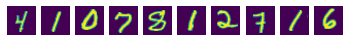

[0 0 0 1 1 1 0 1 0 0]


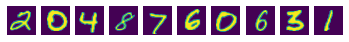

[1 1 0 0 1 1 0 1 1 1]


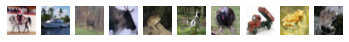

[1 0 1 1 1 0 1 0 0 0]


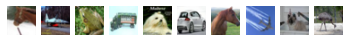

In [6]:
dataset.plot_images(MNIST_TRAIN, channels=1)
dataset.plot_images(MNIST_TEST, channels=1)
dataset.plot_images(CIFAR_TRAIN, channels=3)
dataset.plot_images(CIFAR_TEST, channels=3)

## Utility code

In [7]:
def ds_prefix(ds: dataset.Dataset, sz: int) -> dataset.Dataset:
    return dataset.Dataset(name=f"{ds.name}[:{sz}]", xs=ds.xs[:sz], ys=ds.ys[:sz])

def avg_by_cls(xs, ys) -> Tuple[float, float]:
    return (xs[ys == 0].mean(), xs[ys == 1].mean())

def accs_by_cls(clf: thundersvm.SVC, ds: dataset.Dataset) -> Tuple[float, float]:
    return avg_by_cls(clf.predict(ds.xs) == ds.ys, ds.ys)

def fmt_accs(accs: Tuple) -> str:
    return "(" + ", ".join(f"{a:.4f}" for a in accs) + ")"

def print_dict(d: Dict):
    def fmt(v):
            if isinstance(v, tuple):
                return fmt_accs(v)
            elif isinstance(v, float):
                return f"{v:.2e}"
            return v
            
    print({
        k : fmt(v) for
        k, v in d.items()
        if not isinstance(v, np.ndarray)
    })

In [8]:
def eval_ds(
    clf: thundersvm.SVC,
    ds: dataset.Dataset,
    attack_eps: float,
    pgd_step_size: float,
    pgd_num_steps: int,
    batch_size: int
) -> Dict:
    res_dict = dict(
        ds_name=ds.name,
    )
    
    res_dict["accs"] = accs_by_cls(clf=clf, ds=ds)
    
    clf_grad_fn = jthunder.get_grad_decision_function(clf)
    
    xs_pgd = attacks.pgd(
        X=ds.xs, Y=ds.ys,
        grad_func=clf_grad_fn,
        eps=attack_eps, eps_norm=2,
        step_size=pgd_step_size, step_norm=2,
        num_steps=pgd_num_steps,
        pixel_clip=True,
        batch_size=batch_size,
    )
    res_dict["xs_pgd"] = xs_pgd
    
    res_dict["accs_pgd"] = accs_by_cls(clf=clf, ds=dataset.Dataset(xs=xs_pgd, ys=ds.ys))

    sfmargs = res_dict["sfmargs"] = jthunder.decision_function(clf, ds.xs).to_py() * (2 * ds.ys - 1)
    grad_norms = res_dict["grad_norms"] = np.linalg.norm(
        clf_grad_fn(ds.xs),
        axis=-1, ord=2
    )
    
    res_dict["accs_linadv"] = avg_by_cls(grad_norms * attack_eps <= sfmargs, ds.ys)
    
    return res_dict

In [9]:
def eval_clf(
    clf: thundersvm.SVC,
    datasets: dataset.Dataset,
    base_dict: Dict,
    verbose: bool,
    **kwargs,
) -> Dict:
    res_dict: dict = base_dict.copy()
    res_dict.update(dict(
        n_support=list(clf.n_support_),
        b=clf.intercept_[0],
        gam=clf._gamma,
        coef0=clf.coef0,
        **kwargs
    ))
    if verbose: print_dict(res_dict)
    
    res_dict["norm"] = float(jthunder.norm(clf))
    if verbose: print(f"norm={res_dict['norm']}")
    
    res_dict["ds_results"] = []
    for ds in datasets:
        ds_res_dict = eval_ds(clf, ds, **kwargs)
        res_dict["ds_results"].append(ds_res_dict)
        
        if verbose: print_dict(ds_res_dict)
    
    return res_dict

# Begin experiments

In [15]:
RESULTS = {}

### Linear kernel
The code here memory leaks unfortunately :(

In [16]:
%%time
CUR_KEY = "svm-linear"
RESULTS[CUR_KEY] = []
print(f"Running {CUR_KEY}...")

EVAL_KWARGS = dict(
    attack_eps=2.0,
    pgd_step_size=2.0/10,
    pgd_num_steps=20,
    batch_size=512,
    verbose=True
)

for c in [1e-6, 2e-6]:# 4e-6, 8e-6, 1e-5, 2e-5, 1e-4, 1e-3, 1e-2, 1e-1]:
    clf = thundersvm.SVC(kernel="linear", C=c)
    clf.fit(MNIST_TRAIN.xs[:1000], MNIST_TRAIN.ys[:1000])
    
    RESULTS[CUR_KEY].append(eval_clf(
        clf=clf,
        base_dict=dict(c=c),
        datasets=[ds_prefix(MNIST_TRAIN, 512), ds_prefix(MNIST_TEST, 512)],
        verbose=True,
        attack_eps=2.0,
        pgd_step_size=2.0/10,
        pgd_num_steps=20,
        batch_size=512,
    ))

Running svm-linear...
{'c': '1.00e-06', 'n_support': [498, 498], 'b': '9.97e-01', 'gam': '1.28e-03', 'coef0': '0.00e+00', 'attack_eps': '2.00e+00', 'pgd_step_size': '2.00e-01', 'pgd_num_steps': 20, 'batch_size': 512}
norm=9.304795437972994e-07
{'ds_name': 'mnist-train[:512]', 'accs': '(0.0000, 1.0000)', 'accs_pgd': '(0.0000, 1.0000)', 'accs_linadv': '(0.0000, 1.0000)'}
{'ds_name': 'mnist-test[:512]', 'accs': '(0.0000, 1.0000)', 'accs_pgd': '(0.0000, 1.0000)', 'accs_linadv': '(0.0000, 1.0000)'}
{'c': '2.00e-06', 'n_support': [498, 498], 'b': '9.95e-01', 'gam': '1.28e-03', 'coef0': '0.00e+00', 'attack_eps': '2.00e+00', 'pgd_step_size': '2.00e-01', 'pgd_num_steps': 20, 'batch_size': 512}
norm=3.721918175189198e-06
{'ds_name': 'mnist-train[:512]', 'accs': '(0.0000, 1.0000)', 'accs_pgd': '(0.0000, 1.0000)', 'accs_linadv': '(0.0000, 1.0000)'}
{'ds_name': 'mnist-test[:512]', 'accs': '(0.0000, 1.0000)', 'accs_pgd': '(0.0000, 1.0000)', 'accs_linadv': '(0.0000, 1.0000)'}
CPU times: user 1.55 s, 

Natural
[0 0 0 1 1 1 0 1 0 0]


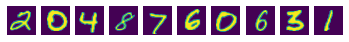


Adversarial
[0 0 0 1 1 1 0 1 0 0]


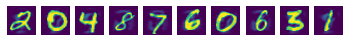

In [19]:
print("Natural")
dataset.plot_images(MNIST_TEST, channels=1)
print()
print("Adversarial")
dataset.plot_images(
    dataset.Dataset(xs=RESULTS["svm-linear"][-1]["ds_results"][1]["xs_pgd"], ys=MNIST_TEST.ys),
    channels=1
)

In [ ]:
def main_plot():
    for split, fmt in zip(["test", "train"], ["o:", "+:"]):
        accs = []
        accs_pgd = []
        for res_dict in RESULTS["svm-linear"]:
            accs.append(sum(res_dict[f"accs_{split}"]) / 2.0)
            accs_pgd.append(sum(res_dict[f"accs_{split}_pgd"]) / 2.0)

        accs = np.array(accs)
        accs_pgd = np.array(accs_pgd)

        plt.plot(1 - accs, 1 - accs_pgd, fmt, label=split)
    
    plt.xlabel("nat-err");
    plt.ylabel("adv-err");
    plt.legend(bbox_to_anchor=(1, 1), loc='upper right', ncol=1);
    
plt.figure(figsize=(12, 4))
    
plt.subplot(1, 2, 1)
main_plot()

plt.subplot(1, 2, 2)
main_plot()
plt.xlim(0, 0.25);
plt.ylim(0.8, 1.01);

We have a tradeoff between robustness and accuracy here!

Hypothesis: This is due to mismatch between linear model and dataset
which cannot be linearly separated in a robust fashion.

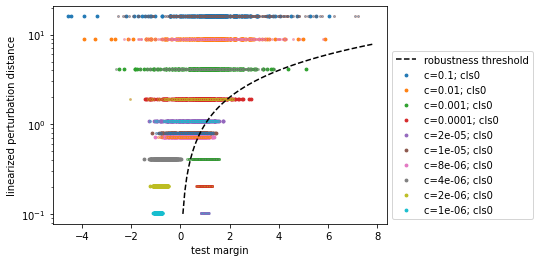

In [15]:
for i, res_dict in enumerate(reversed(RESULTS["svm-linear"])):
    plt.scatter(
        x=res_dict["test_margins"][res_dict["test_ys"] == 0],
        y=2.0 * res_dict["test_grad_norms"][res_dict["test_ys"] == 0],
        s=8, alpha=1, label=f"c={res_dict['c']}; cls0",
        color=f"C{i}"
    )
    plt.scatter(
        x=res_dict["test_margins"][res_dict["test_ys"] == 1],
        y=2.0 * res_dict["test_grad_norms"][res_dict["test_ys"] == 1],
        s=4, alpha=0.5, facecolors=None,
        edgecolors=f"C{i+5}"
    )
    
plt.plot(
    np.linspace(0.1, plt.xlim()[1], 100),
    np.linspace(0.1, plt.xlim()[1], 100),
    '--', color="black",
    label="robustness threshold"
)
    
plt.yscale("log")
plt.xlabel("test margin");
plt.ylabel("linearized perturbation distance");
plt.legend(bbox_to_anchor=(1, 0), loc='lower left', ncol=1);

## RBF kernel

In [ ]:
%%time
CUR_KEY = "svm-rbf"
RESULTS[CUR_KEY] = []
print(f"Running {CUR_KEY}...")

EVAL_KWARGS = dict(
    attack_eps=2.0,
    pgd_step_size=2.0/10,
    pgd_num_steps=20,
    batch_size=512,
    verbose=True
)

for c in [1e-3, 2e-3, 4e-3, 8e-3, 1e-2, 1e-1, 1, 10, 100]:
    clf = thundersvm.SVC(kernel="rbf", C=c)
    clf.fit(MNIST_TRAIN.xs, MNIST_TRAIN.ys)
    
    for ds in [ds_prefix(MNIST_TRAIN, 512), ds_prefix(MNIST_TEST, 512)]:
        RESULTS[CUR_KEY].append(
            eval_clf(
                clf=clf,
                ds=ds,
                base_dict=dict(c=c),
                **EVAL_KWARGS
            )
        )

Running svm-rbf...
{'c': '1.00e-03', 'ds_name': 'mnist-train', 'n_support': [29404, 29404], 'b': '7.54e-01', 'gam': '1.28e-03', 'coef0': '0.00e+00', 'attack_eps': '2.00e+00', 'pgd_step_size': '2.00e-01', 'pgd_num_steps': 20, 'norm': '6.14e+00', 'accs': '(0.0000, 1.0000)', 'accs_pgd': '(0.0000, 1.0000)', 'accs_linadv': '(0.0000, 1.0000)'}
{'c': '1.00e-03', 'ds_name': 'mnist-test', 'n_support': [29404, 29404], 'b': '7.54e-01', 'gam': '1.28e-03', 'coef0': '0.00e+00', 'attack_eps': '2.00e+00', 'pgd_step_size': '2.00e-01', 'pgd_num_steps': 20, 'norm': '6.14e+00', 'accs': '(0.0000, 1.0000)', 'accs_pgd': '(0.0000, 1.0000)', 'accs_linadv': '(0.0000, 1.0000)'}


Natural
[0 0 0 1 1 1 0 1 0 0]


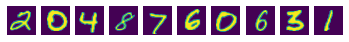


Adversarial
[0 0 0 1 1 1 0 1 0 0]


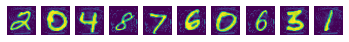

In [20]:
print("Natural")
dataset.plot_images(MNIST_TEST, channels=1)
print()
print("Adversarial")
dataset.plot_images(
    dataset.Dataset(xs=RESULTS["svm-rbf"][-1]["xs_test_pgd"], ys=MNIST_TEST.ys),
    channels=1
)

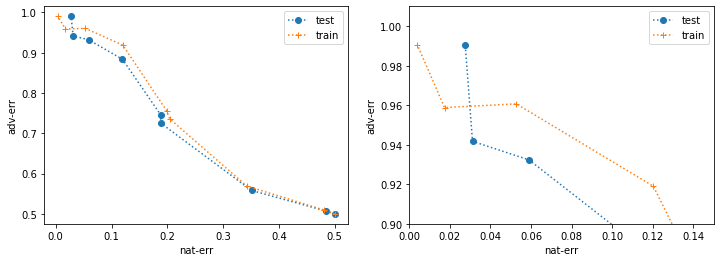

In [39]:
def main_plot():
    for split, fmt in zip(["test", "train"], ["o:", "+:"]):
        accs = []
        accs_pgd = []
        for res_dict in RESULTS["svm-rbf"]:
            accs.append(sum(res_dict[f"accs_{split}"]) / 2.0)
            accs_pgd.append(sum(res_dict[f"accs_{split}_pgd"]) / 2.0)

        accs = np.array(accs)
        accs_pgd = np.array(accs_pgd)

        plt.plot(1 - accs, 1 - accs_pgd, fmt, label=split)
    
    plt.xlabel("nat-err");
    plt.ylabel("adv-err");
    plt.legend(bbox_to_anchor=(1, 1), loc='upper right', ncol=1);

plt.figure(figsize=(12, 4))
    
plt.subplot(1, 2, 1)
main_plot()

plt.subplot(1, 2, 2)
main_plot()
plt.xlim(0, 0.15);
plt.ylim(0.9, 1.01);

Tradeoff between nat-err and adv-err also seen for the rbf kernel.

In [101]:
res_dfs = []
for res_dict in RESULTS["svm-rbf"]:
    cur_df = pd.DataFrame(dict(
        margin=res_dict["test_margins"],
        grad_norm=res_dict["test_grad_norms"],
        attack_eps=res_dict["attack_eps"],
        y=res_dict["test_ys"],
        test=True,
        c=res_dict["c"]
    ))
    res_dfs.append(cur_df)

svm_df = pd.concat(res_dfs, ignore_index=True)
svm_df

,margin,grad_norm,attack_eps,y,test,c
0,-0.779886,0.112831,2.0,0,True,0.001
1,-0.632773,0.105940,2.0,0,True,0.001
2,-0.910703,0.112087,2.0,0,True,0.001
3,0.734785,0.116827,2.0,1,True,0.001
4,1.096742,0.114431,2.0,1,True,0.001
...,...,...,...,...,...,...
4603,1.688653,4.570414,2.0,0,True,100.000
4604,4.709659,4.366617,2.0,1,True,100.000
4605,1.879041,4.467051,2.0,0,True,100.000
4606,-1.655566,4.450921,2.0,0,True,100.000


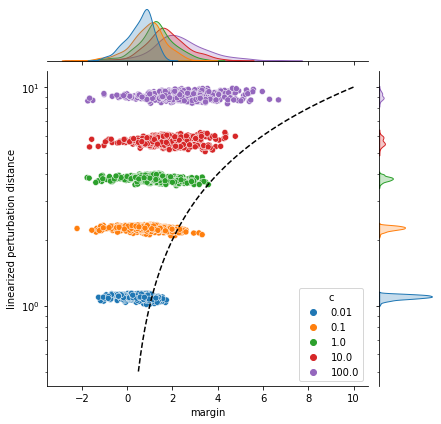

In [128]:
sub_df = svm_df[(svm_df.c >= 0.01)]
#hues = pd.Series(zip(sub_df.c, sub_df.y), index=sub_df.index, dtype="category")
jplt = sns.jointplot(
    x=sub_df.margin,
    y=sub_df.grad_norm * sub_df.attack_eps,
    hue=sub_df.c.astype("category"),
);
jplt.ax_joint.plot(
    np.linspace(0.5, 10, 100),
    np.linspace(0.5, 10, 100),
    '--', color="black",
    label="robustness threshold"
);
jplt.ax_joint.set_ylabel("linearized perturbation distance");
plt.yscale("log");

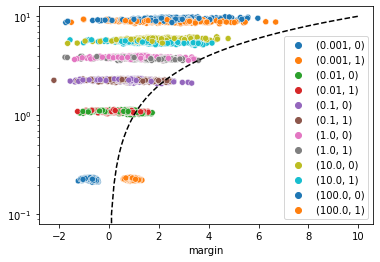

In [129]:
sub_df = svm_df[(svm_df.c <= 0.001) | (svm_df.c >= 0.01)]
hues = pd.Series(zip(sub_df.c, sub_df.y), index=sub_df.index, dtype="category")
splt = sns.scatterplot(x=sub_df.margin, y=sub_df.grad_norm * sub_df.attack_eps, hue=hues, palette=sns.color_palette(n_colors=hues.nunique()));
splt.plot(
    np.linspace(0, 10, 100),
    np.linspace(0, 10, 100),
    '--', color="black",
    label="robustness threshold"
);
plt.yscale("log");

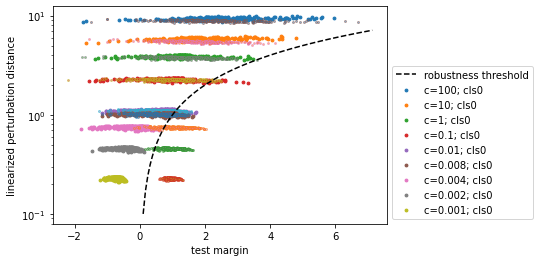

In [22]:
for i, res_dict in enumerate(reversed(RESULTS["svm-rbf"])):
    plt.scatter(
        x=res_dict["test_margins"][res_dict["test_ys"] == 0],
        y=2.0 * res_dict["test_grad_norms"][res_dict["test_ys"] == 0],
        s=8, alpha=1, label=f"c={res_dict['c']}; cls0",
        color=f"C{i}"
    )
    plt.scatter(
        x=res_dict["test_margins"][res_dict["test_ys"] == 1],
        y=2.0 * res_dict["test_grad_norms"][res_dict["test_ys"] == 1],
        s=4, alpha=0.5, facecolors=None,
        edgecolors=f"C{i+5}"
    )
    
plt.plot(
    np.linspace(0.1, plt.xlim()[1], 100),
    np.linspace(0.1, plt.xlim()[1], 100),
    '--', color="black",
    label="robustness threshold"
)
    
plt.yscale("log")
plt.xlabel("test margin");
plt.ylabel("linearized perturbation distance");
plt.legend(bbox_to_anchor=(1, 0), loc='lower left', ncol=1);